# Loading Dependencies

In [4]:
#import pycromanager 
from pycromanager import Core, Acquisition, multi_d_acquisition_events, Dataset
from matplotlib.pyplot import * 
import numpy as np
from PIL import Image

import random

In [5]:
core = Core()

In [4]:
core

# percentile

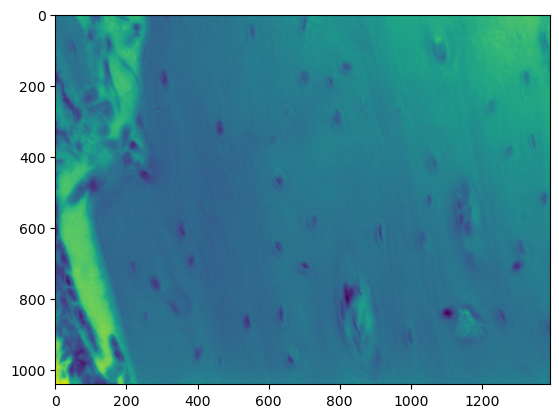

In [6]:
core.clear_roi()
core.snap_image()
tagged_image = core.get_tagged_image()

pixels = np.reshape(tagged_image.pix,
                    newshape=[tagged_image.tags['Height'], tagged_image.tags['Width'],4])
imshow(pixels.sum(2))

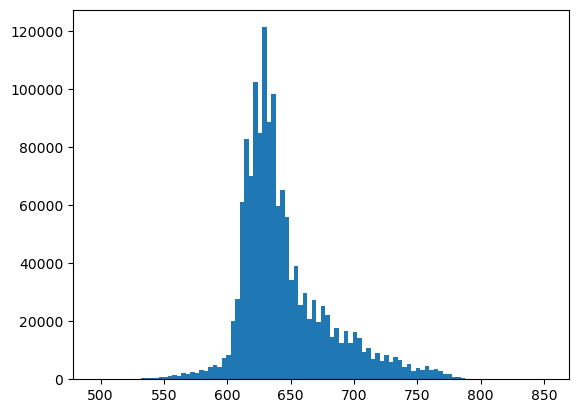

In [8]:
hist(pixels.sum(2).ravel(),100);

In [9]:
img = pixels.sum(2)
img.size* .00001

14.4768

In [22]:
len(img[img==np.percentile(img.ravel(),0.001)])

16

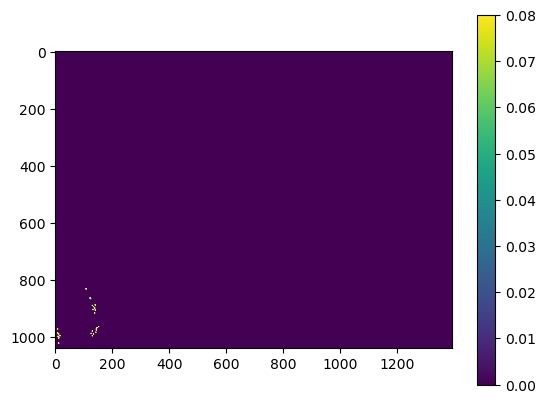

In [27]:
maxima = (img==np.percentile(img,99.9))
imshow(maxima,vmax=.08)
colorbar()


In [28]:
maxima.shape

(1040, 1392)

In [54]:
def get_rois(coord,d, shape_x, shape_y):
    center_d = int(d/2)

    max_im_list = []
    #iterate through maximas
    for max in coord:
        
        #clear roi
        core.clear_roi()

        x = int(max[0]-center_d)
        y = int(max[1]-center_d)

        if x < 0: x = 0
        elif x > shape_x-d: x =shape_x-d
        if y < 0: y = 0
        elif y > shape_y-d: y = shape_y-d
        
        #setting roi
        core.set_roi(x, y, d,d)
        core.snap_image()
        tagged_image = core.get_tagged_image()

        #show rois
        pixels = np.reshape(tagged_image.pix,
                    newshape=[tagged_image.tags['Height'], tagged_image.tags['Width'],4])
        figure()
        imshow(pixels.sum(2))
        
    
    

In [79]:
def trans_coord(coord):
    factor = core.get_pixel_size_um()
    offset_x = core.get_x_position()
    offset_y = core.get_y_position()

    new_coord = []
    for max in coord:
        new_x = (max[0]*factor) +offset_x
        new_y = (max[1]*factor) +offset_y
        new_coord.append((new_x,new_y))
        
    return new_coord

In [58]:
def get_max():

    #clear roi
    core.clear_roi()
    
    #get image
    core.snap_image()
    tagged_image = core.get_tagged_image()
    pixels = np.reshape(tagged_image.pix,
                        newshape=[tagged_image.tags['Height'], tagged_image.tags['Width'],4])
    imshow(pixels)

    #size
    size_x = pixels.shape[1]
    size_y = pixels.shape[0]

    #avg of im size
    avg = (size_x+size_y)/2

    #maxima
    maxima = (img==np.percentile(img.ravel(), 99.99))

    #coords
    index = np.where(maxima)
    coord = list(zip(index[1], index[0]))
    d = int(avg/10)

    #zoom
    return get_rois(coord,d,size_x,size_y)
    

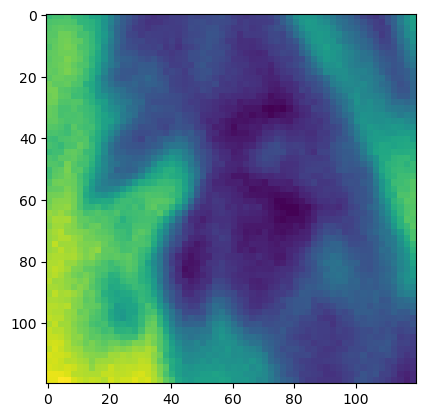

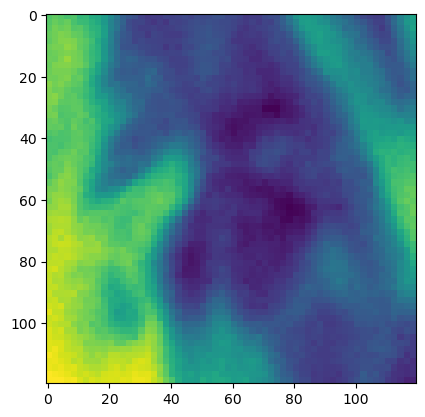

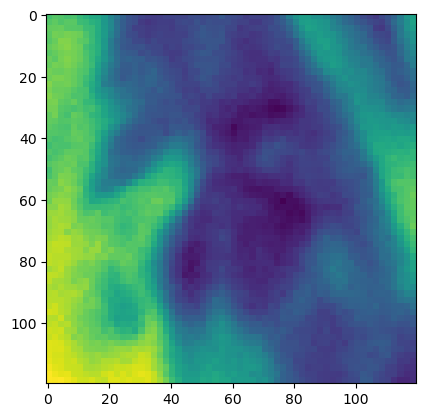

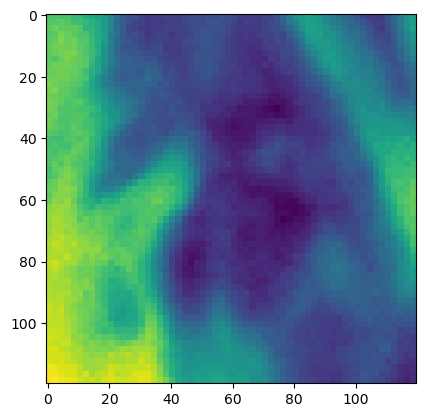

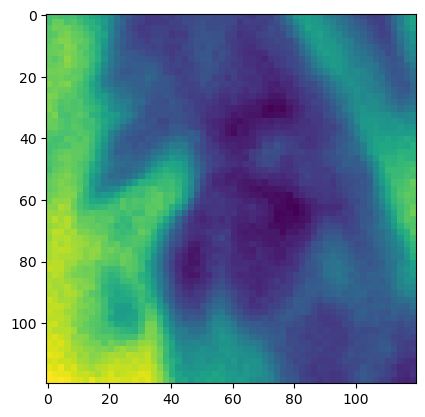

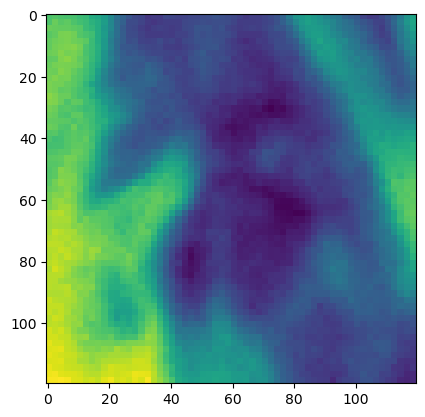

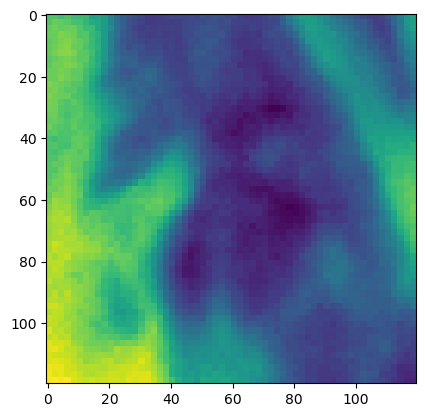

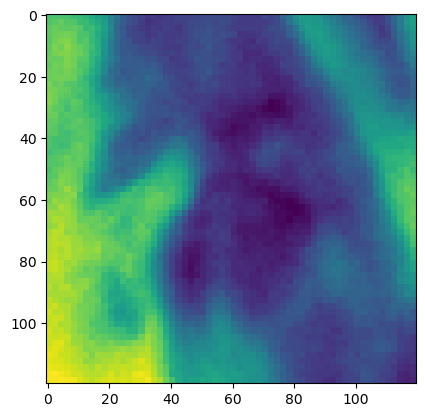

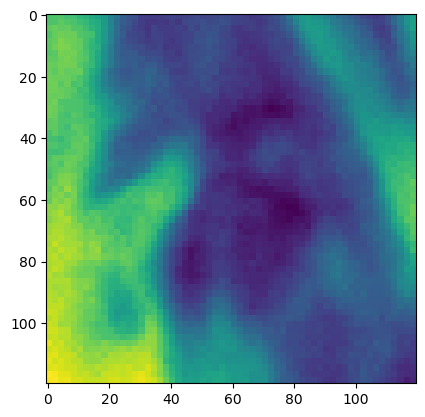

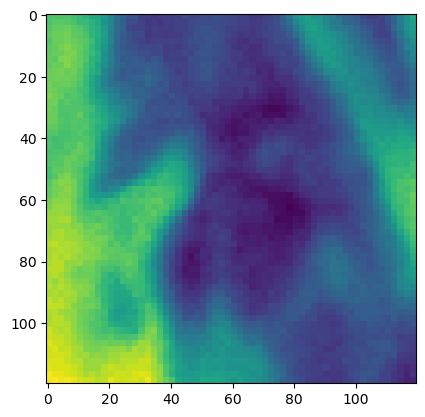

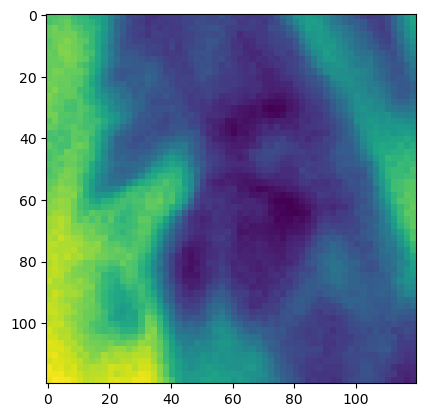

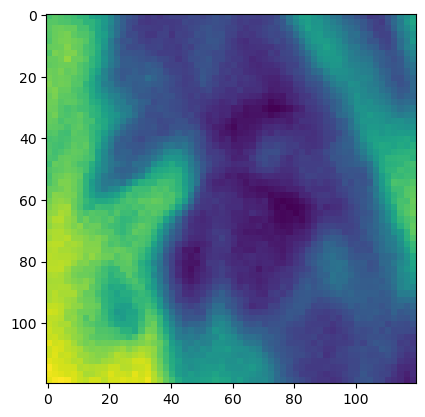

<Figure size 640x480 with 0 Axes>

In [59]:
get_max()

# Functions

In [62]:
def center_grid(x, y) :
    """Create 3x3 grid centered on x,y with d distance to other squares

        Parameters:
        x (int): x coordinate
        y (int): y coordinate
        d (int): distance of squares from center

        Returns:
        ndarray: 3x3 grid
    """

    #get size of image (pixels)
    core.snap_image()
    tagged_image = core.get_tagged_image()
    pixels = np.reshape(tagged_image.pix,
                        newshape=[tagged_image.tags['Height'], tagged_image.tags['Width']])

    ##get size of image (um), assuming square
    d = pixels.shape[0] * core.get_pixel_size_um()

    
    return np.array([[x-d,y-d], [x,y-d], [x+d,y-d],
                     [x-d,y], [x,y], [x+d,y],
                     [x-d,y+d], [x,y+d], [x+d,y+d]])


In [37]:
def acq_images(filename, directory, xy_coords):
    """Acquire 3x3 grid of images centered around x,y

        Parameters:
        filename (str): file name
        directory (str): directory path to file
        xy_coords (ndarray): 3x3 grid of coordinates to acquire pictures of

        Returns:
        NDTiffDataset: dataset of acq images
    """
    
    with Acquisition(directory=directory, 
                        name=filename) as acq:
        events = multi_d_acquisition_events(xy_positions=xy_coords)
        acq.acquire(events)  
                            
        return acq.get_dataset()

In [39]:
def images_list(dataset):
    """Create a list of images from dataset

        Parameters:
        dataset (NDTiffDataset): a dataset of acq images

        Returns:
        list: list of images
    """
    
    ax = dataset.axes
    amount = ax["position"]

    im_list = []
    for i in amount:
        im_list.append(Image.fromarray(dataset.read_image(position=i)))
    
    return im_list
        

In [40]:
def stitch_images(lst, n, m):
    """Create a mosaic of images in an nxm grid

        Parameters:
        lst (list): list of images
        n (int): n rows
        m (int): m cols

        Returns:
        Image: nxm grid of images
    """
    
    sizing = lst[0].size
    mod = lst[0].mode
    #nxwidth of image, mxheight of images
    new_image = Image.new(mode=mod, size=(n*sizing[0], m*sizing[1]))

    iter=0
    for i in range(m):
        for j in range(n):
            #coord are (x,y)
            new_image.paste(lst[iter], (j*sizing[0], i*sizing[1]))
            iter+=1
    return new_image

In [41]:
def get_2dmaxima(image,kernelsize=3):
    """Get maximas of image

        Parameters:
        image (Image): image to get maximas of
        kernelsize (int): size of filter used to find maximas

        Returns:
        ndarray: maximas of image
    """
    # convert image to array
    image_array= np.array(image)
    
    return image_array == maximum_filter(image_array, footprint=np.ones((kernelsize,kernelsize)))

In [79]:
def get_coord_maxima(image, xy_origin, local_cord=False):
    """Get coordinates of maximas

        Parameters:
        image (Image): maximas image

        Returns: list of maxima coordinates
        
    """
    #convert image to array
    image_array= np.array(image)
    
    index = np.where(image_array!= 0)

    #local cords
    lcoord = list(zip(index[0], index[1]))

    if local_cord:
        return lcoord

    #global cords (assuming square)
    gcoord = []
    for xy in lcoord:
        x = (xy[0] * core.get_pixel_size_um()) + xy_origin[0]
        y = (xy[1] * core.get_pixel_size_um()) + xy_origin[1]
        gcoord.append((x,y))

        
    return gcoord

def offset(list):
    #stage coord = imCoord * a + b
    #a = um per pixel, b = x (or y) - total pix *um per pix
    
    #pixel size in total
    pix = int(core.get_property('Camera', 'OnCameraCCDXSize'))
    
    #um / pixel
    scale =core.get_pixel_size_um()
    
    um = pix*scale
    
    #in actual implementation would be coord from orig input to grid-coord-maker
    x_origin = core.get_x_position()
    y_origin = core.get_y_position()
    
    new_list = []
    
    for i in list:
        new_x = i[0] * scale + (x_origin-um)
        new_y = i[1] * scale + (y_origin-um)
        new_list.append((new_x,new_y))
    
    return new_list
        
    

In [70]:
def acq_maxima(x,y, fname,dirpath, show_im=True):
    """Acquire images and get maximas

        Parameters:
        x (int): x coordinate to center grid on
        y (int): y coordinate to center grid on
        d (int): distance from center to squares of grid
        fname (str): name of file saving images to 
        dirpath (str): path to file
        show_im (bool): Optional, show images of mosaic and local maximas 

        Returns:
        imgs_max (ndarray): local maximas of mosaic
        coord (list): coordinates of local maximas
        stitched_im (ndarray): mosaic of acq images
        d (int): distance between squares of grid (used for zoom function)
        size (tuple of ints): size of image (used for zoom function)
        
    """
    xy = center_grid(x,y)

    #acq imagaes
    dataset = acq_images(fname,dirpath,xy)
    im_lst = images_list(dataset)

    #stitch images
    stitch_im = stitch_images(im_lst,3,3)
    stitched_im= np.array(stitch_im)


    #get maxima
    imgs_max = get_2dmaxima(stitched_im)
    
    #get maxima's coords
    coord = get_coord_maxima(imgs_max,xy[0])
     

    if show_im:
        imshow(stitched_im)
        figure(), imshow(imgs_max)

    
    return imgs_max,coord,stitched_im

In [159]:
from scipy.ndimage import maximum_filter
from scipy.ndimage import minimum_filter

In [198]:
#footprint_size = 3
#imshow(maximum_filter(img, size=footprint_size),interpolation='nearest')
#figure()
#imshow(minimum_filter(img, size=footprint_size),interpolation='nearest')

In [197]:
#maximum_filter(img, size=footprint_size)

In [ ]:
def zoom2(coord):
    
    #get size of image (pixels)
    core.snap_image()
    tagged_image = core.get_tagged_image()
    pixels = np.reshape(tagged_image.pix,
                        newshape=[tagged_image.tags['Height'], tagged_image.tags['Width'],4])

    ##get size of image (um), assuming square
    pix_dx = pixels.shape[0]
    d = pix_d * core.get_pixel_size_um()
    d=d/2

    #iterate through maximas
    for max in coord[:5]:
        #center maxima
        core.set_xy_position(max[0]-d,max[1]-d)
        core.waitForSystem()
        #snap new image
        core.snap_image()
        tagged_image = core.get_tagged_image()
        pixels = np.reshape(tagged_image.pix,
                            newshape=[tagged_image.tags['Height'], tagged_image.tags['Width']])
        
        #get maxima
        imgs_max = get_2dmaxima(stitched_im)
    
        #get maxima's local coords
        local_coord = get_coord_maxima(imgs_max,xy[0],local_cord=True)

        #setting roi
        #size down by 10
        pix_d = pix_d/10

        for spec_max in local_coord:
            
        
        
        ##TODO: finish this off
    
    

In [273]:
def zoom(x,y,d_old, size_old, q, fname,dirpath):
    """Acquire images and get maximas around a chosen local maxima

        Parameters:
        x (int): x coordinate of chosen local maxima to center grid on
        y (int): y coordinate of chosen local maxima to center grid on
        d_old (int): distance btwn squares of grid used in previous iterations
        size_old (tuple of ints): size of graph on image used in previous iterations
        q (int): factor sizing down by
        fname (str): name of file saving images to 
        dirpath (str): path to file
         

        Returns:
        imgs_max (ndarray): local maximas of mosaic
        coord (list): coordinates of local maximas
        stitched_im (ndarray): mosaic of acq images
        d_new (int): distance between squares of grid around local maxima (used for zoom function)
        size_new (tuple of ints): new size of graph on image (used for zoom function)
        
    """
    
    #new xy, coord from prev / size of image from prev
    x_spec,y_spec = x/size_old[0],y/size_old[1]
    d_new = d_old/q

    imgs_max,coord,stitched_im, d_new, size_irr= acq_maxima(x_spec,y_spec,d_new, fname,dirpath, show_im=False)
    
    
    size_new = [(size_old[0]/q), (size_old[1]/q)]

    #show stitched and maxima images (resized)
    figure(), imshow(stitched_im, extent=[0,size_new[0], size_new[1],0])
    figure(), imshow(imgs_max, extent=[0,size_new[0], size_new[1],0])

    return imgs_max,coord,stitched_im, d_new,size_new
    

# tests

In [9]:
fname= 'xy_tile_try28'
dirpath = r"C:\Users\lociu\Desktop\PriyaM\Data\image_collection"

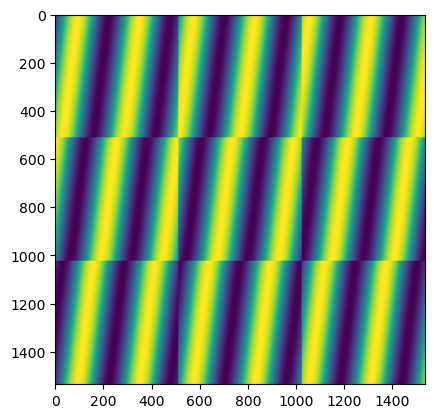

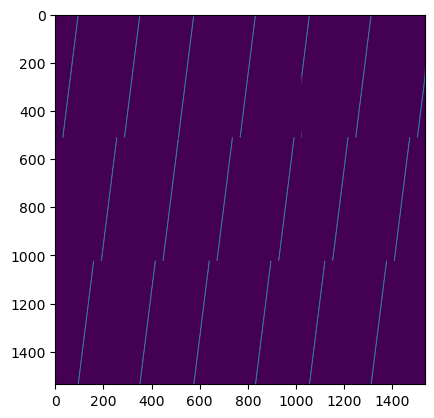

In [64]:
#acq_maxima
imgs_max,coord,stitched_im = acq_maxima(2,2,fname,dirpath)

In [69]:
for i in coord[:10]:
    print(i[0])

-510
-510
-510
-510
-510
-510
-509
-509
-509
-509


In [275]:
#random local maxima
x,y = random.choice(coord)

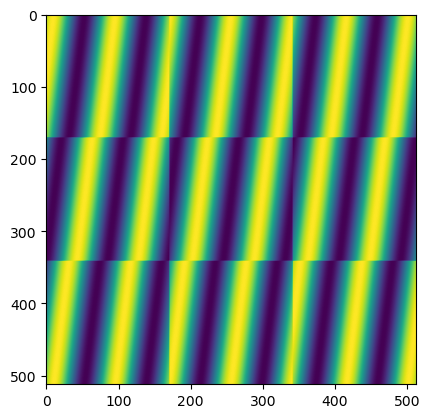

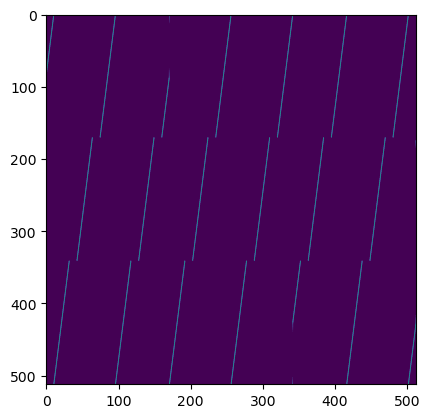

In [276]:
#zoom
imgs_max_2,coord_2,stitched_im_2,d_2,size_2 = zoom(x,y,d, size, 3, fname,dirpath)

In [277]:
#random local maxima
x_2,y_2 = random.choice(coord)

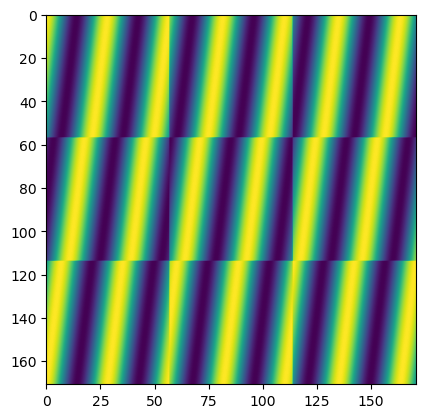

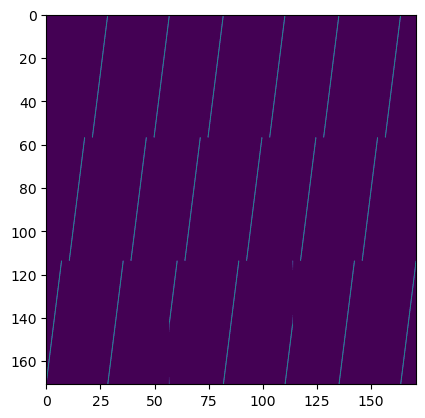

In [278]:
#zoom
imgs_max_3,coord_3,stitched_im_3,d_3,size_3 = zoom(x_2,y_2,d_2, size_2, 3, fname,dirpath)